# Предсказание оттока пользователей
Домашне задание к 3 модулю продвинутого потока DLS (весна 2021)

* author: Юрий Сарычев
* nick: [sarycheff](https://www.kaggle.com/sarycheff)
* date: 08/03/2021

Установка библиотек (при необходимости)

In [70]:
! pip install catboost

##### Подключение библиотек для обработки данных

In [71]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

##### Подключение библиотек для визуализация данных

In [72]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)
import seaborn as sns

##### Импорт моделей

In [73]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool, cv
import xgboost as xgb
from sklearn import metrics

В качестве метрики используем ROC-AUC

In [74]:
from sklearn.metrics import roc_auc_score

***

In [75]:
data = pd.read_csv('./train.csv') # загружаем тренировочный набор данных
data_test = pd.read_csv('./test.csv') # загружаем тестовый набор данных

In [76]:
data.shape # форма массива

(5282, 20)

In [77]:
data.head(10) # смотрим первые 10 записей

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
5,25,19.80,475.2,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
6,27,90.15,2423.4,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic),0
7,1,45.70,45.7,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
9,72,61.20,4390.25,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0


In [78]:
data.info() # анализируем используемые типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

>Колонка 'TotalSpent' явно числовая, но при этом имеет тип 'object'

In [79]:
num_TotalSpent = pd.to_numeric(data['TotalSpent'], errors='coerce')
data[num_TotalSpent.isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Выведем первое проблемное значение:

In [80]:
data['TotalSpent'][1048]

' '

Исправляем датафрейм:

In [81]:
data['TotalSpent'] = num_TotalSpent

In [82]:
data['TotalSpent'].describe()

count    5273.000000
mean     2291.390461
std      2269.014233
min        18.800000
25%       401.100000
50%      1410.250000
75%      3807.350000
max      8684.800000
Name: TotalSpent, dtype: float64

>Теперь тип float64

In [83]:
data.isna().sum(axis=0)

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

>**В колонке 'TotalSpent' 9 значений NaN. Заменим их на 0, поскольку они соответствуют 'ClientPeriod' = 0:**

In [84]:
imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0)
data['TotalSpent'] = imputer.fit_transform(data['TotalSpent'].values.reshape(-1,1))[:,0];

data_test['TotalSpent'] = pd.to_numeric(data_test['TotalSpent'], errors='coerce')
data_test['TotalSpent'] = imputer.fit_transform(data_test['TotalSpent'].values.reshape(-1,1))[:,0];

# Аналогичного результата можно было добиться и проще:
# data['TotalSpent'].fillna(0, inplace=True)
# data_test['TotalSpent'].fillna(0, inplace=True)

In [85]:
data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2287.486161,0.159409,0.262022
std,24.550326,30.176464,2269.049195,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000,0.000000
25%,9.000000,35.462500,395.725000,0.000000,0.000000
50%,29.000000,70.400000,1405.650000,0.000000,0.000000
75%,55.000000,90.050000,3795.212500,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


In [86]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Разделим наш датасет на признаки (features) и метки (labels):

In [87]:
X = data.drop('Churn', axis=1)
y = data['Churn']

### Анализ числовых данных

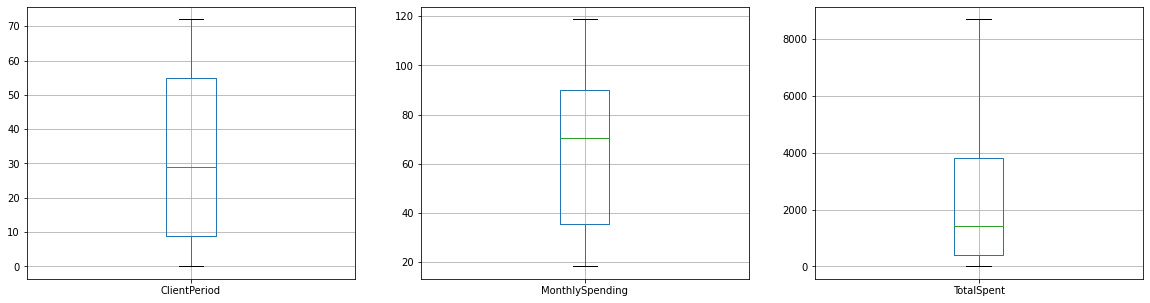

In [88]:
fig, axes = plt.subplots(1, 3)

X.boxplot(column='ClientPeriod', ax=axes[0])
X.boxplot(column='MonthlySpending', ax=axes[1])
X.boxplot(column='TotalSpent', ax=axes[2]);

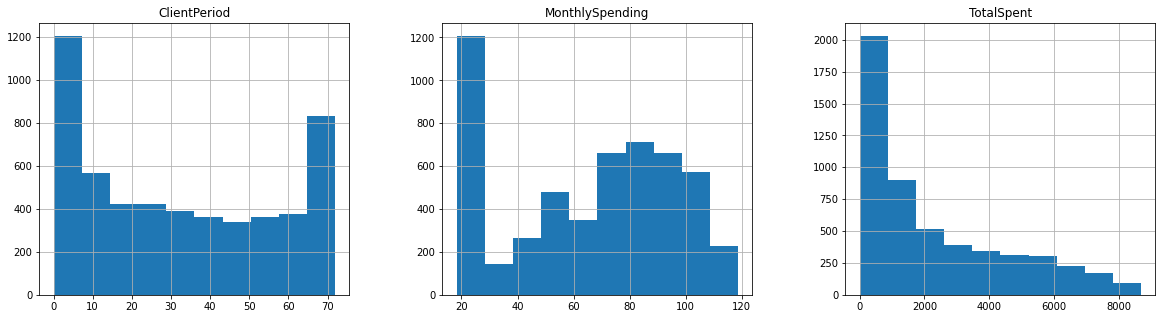

In [89]:
fig, axes = plt.subplots(1, 3)

X.hist(column='ClientPeriod', ax=axes[0])
X.hist(column='MonthlySpending', ax=axes[1])
X.hist(column='TotalSpent', ax=axes[2]);

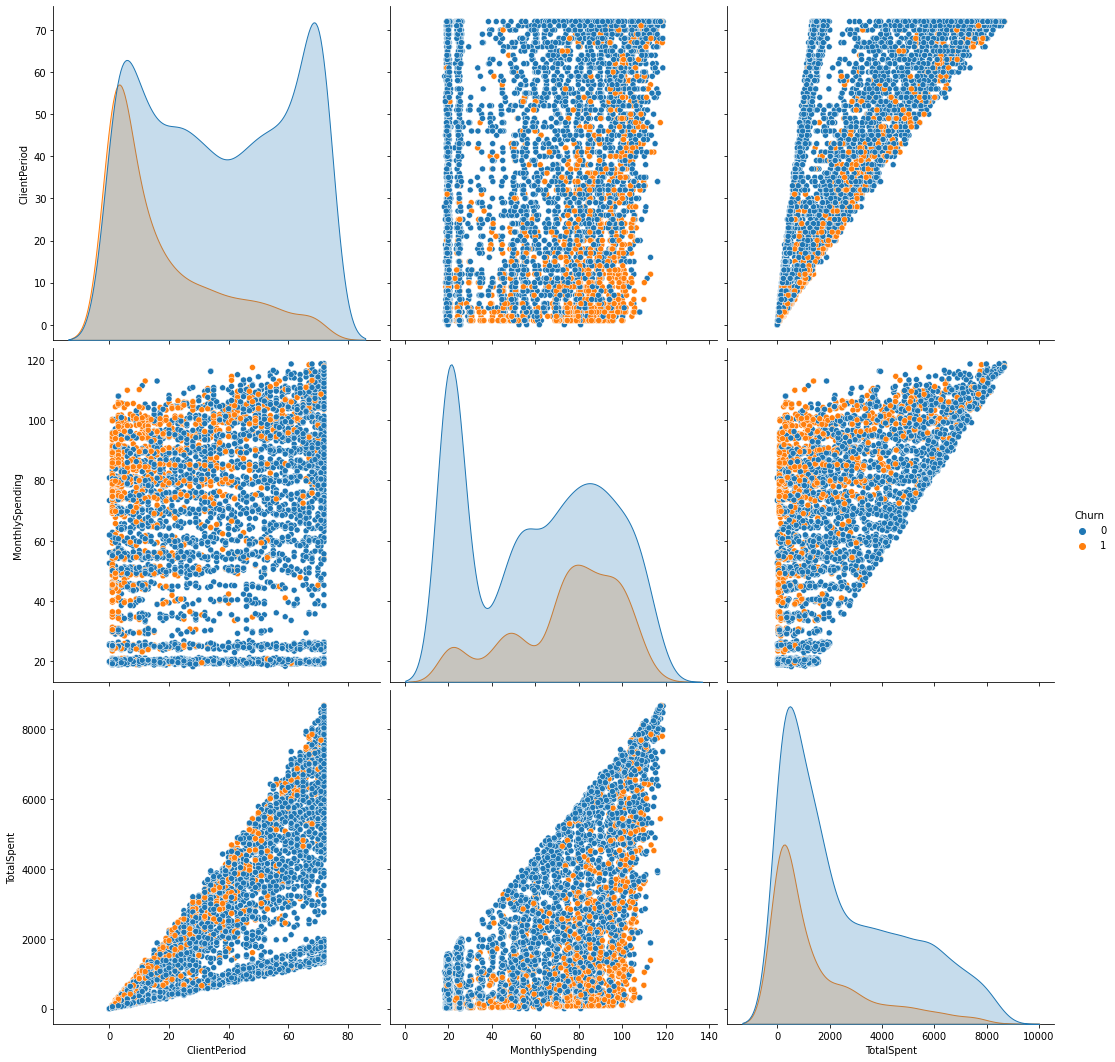

In [90]:
sns.pairplot(data.drop('IsSeniorCitizen', axis=1), height=5, hue="Churn");

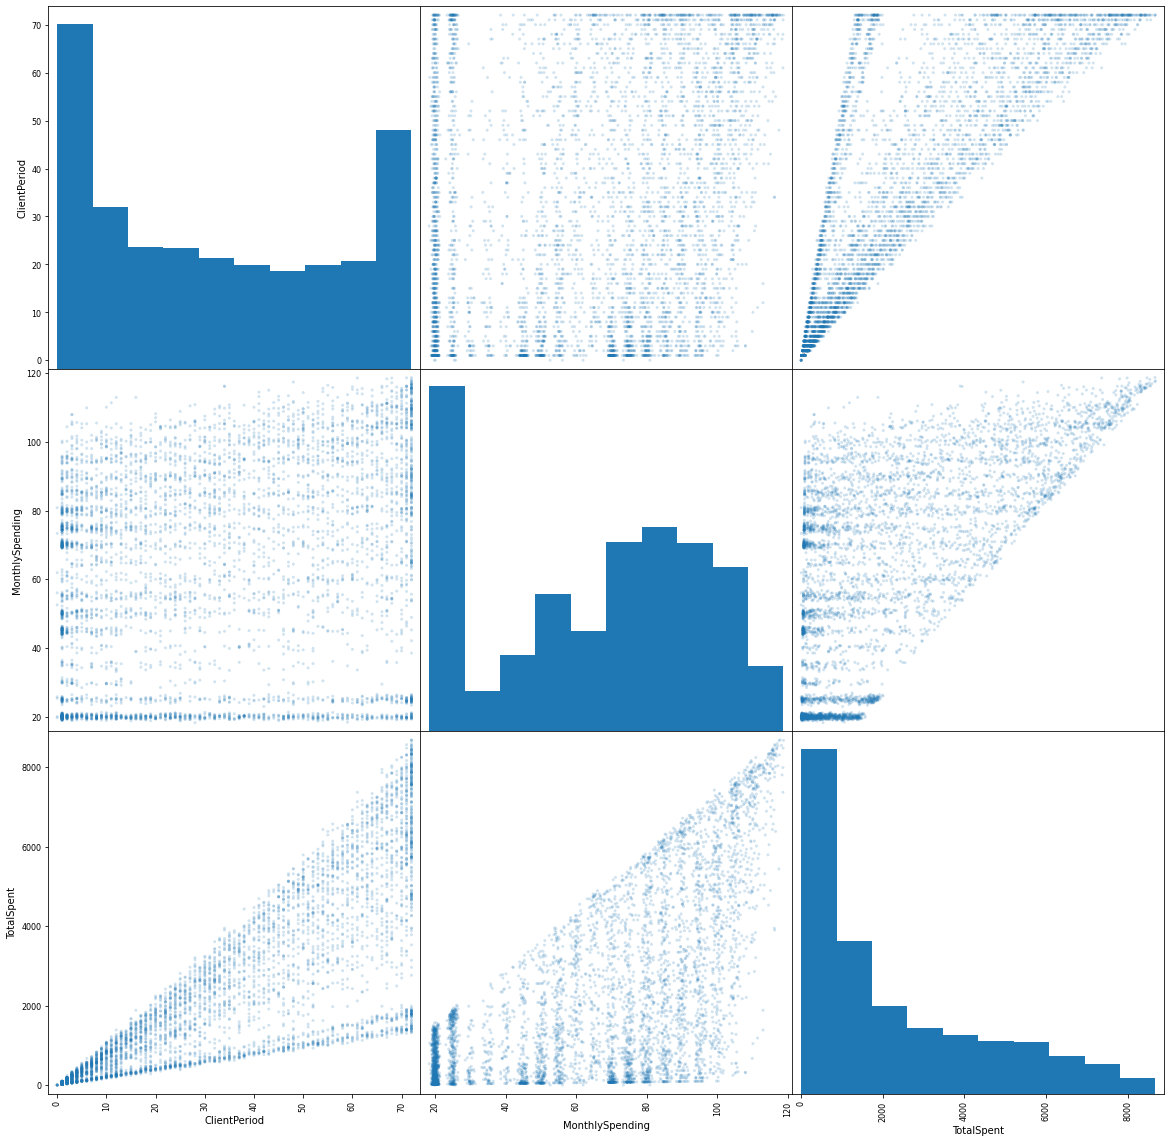

In [91]:
pd.plotting.scatter_matrix(X.drop('IsSeniorCitizen', axis=1), alpha=0.2, figsize=(20, 20));

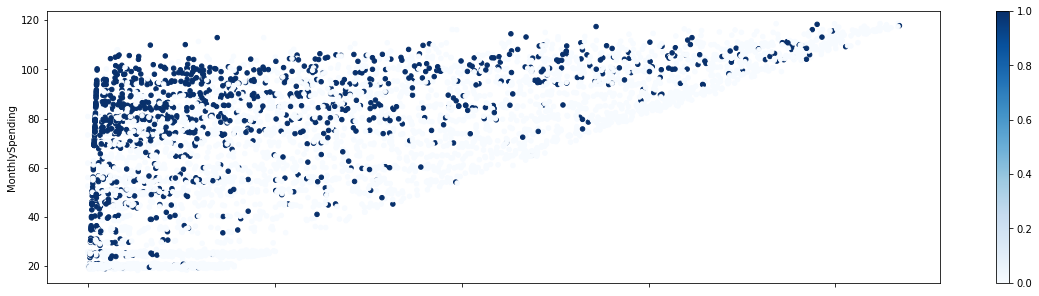

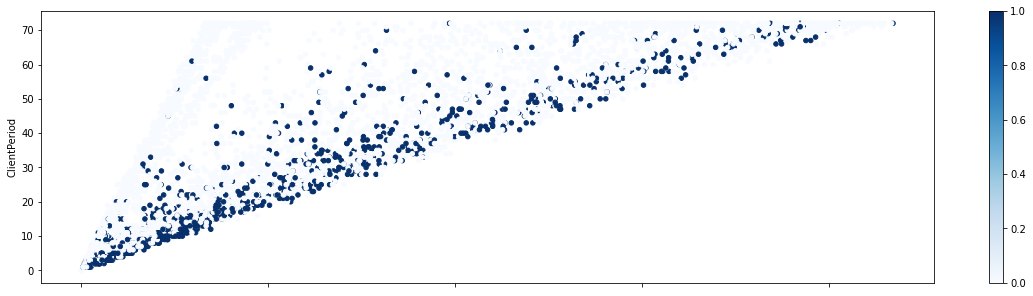

In [92]:
X.plot.scatter(x='TotalSpent', y='MonthlySpending', cmap=cm.Blues, c=y)
X.plot.scatter(x='TotalSpent', y='ClientPeriod', cmap=cm.Blues, c=y);

In [93]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(4)

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen
ClientPeriod,1.0000,0.2494,0.8267,0.0116
MonthlySpending,0.2494,1.0000,0.6520,0.2155
TotalSpent,0.8267,0.6520,1.0000,0.0946
IsSeniorCitizen,0.0116,0.2155,0.0946,1.0000


>Наблюдается довольно сильная корреляция между данными в колонках 'ClientPeriod' и 'TotalSpent', что логично - чем дольше клиент обслуживается, тем больше денег он потратил в итоге.

### Анализ категориальных данных

In [94]:
X.describe(include='object')

,Sex,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
count,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,2655,2705,3676,4761,2511,2341,2612,2332,2317,2604,2099,2081,2920,3148,1786


Выведем значения категориальных признаков:

In [95]:
[print(name, X[name].unique()) for name in X[cat_cols]];

Sex ['Male' 'Female']
IsSeniorCitizen [0 1]
HasPartner ['Yes' 'No']
HasChild ['Yes' 'No']
HasPhoneService ['Yes' 'No']
HasMultiplePhoneNumbers ['No' 'Yes' 'No phone service']
HasInternetService ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService ['No internet service' 'No' 'Yes']
HasOnlineBackup ['No internet service' 'No' 'Yes']
HasDeviceProtection ['No internet service' 'No' 'Yes']
HasTechSupportAccess ['No internet service' 'Yes' 'No']
HasOnlineTV ['No internet service' 'No' 'Yes']
HasMovieSubscription ['No internet service' 'No' 'Yes']
HasContractPhone ['One year' 'Two year' 'Month-to-month']
IsBillingPaperless ['No' 'Yes']
PaymentMethod ['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)']


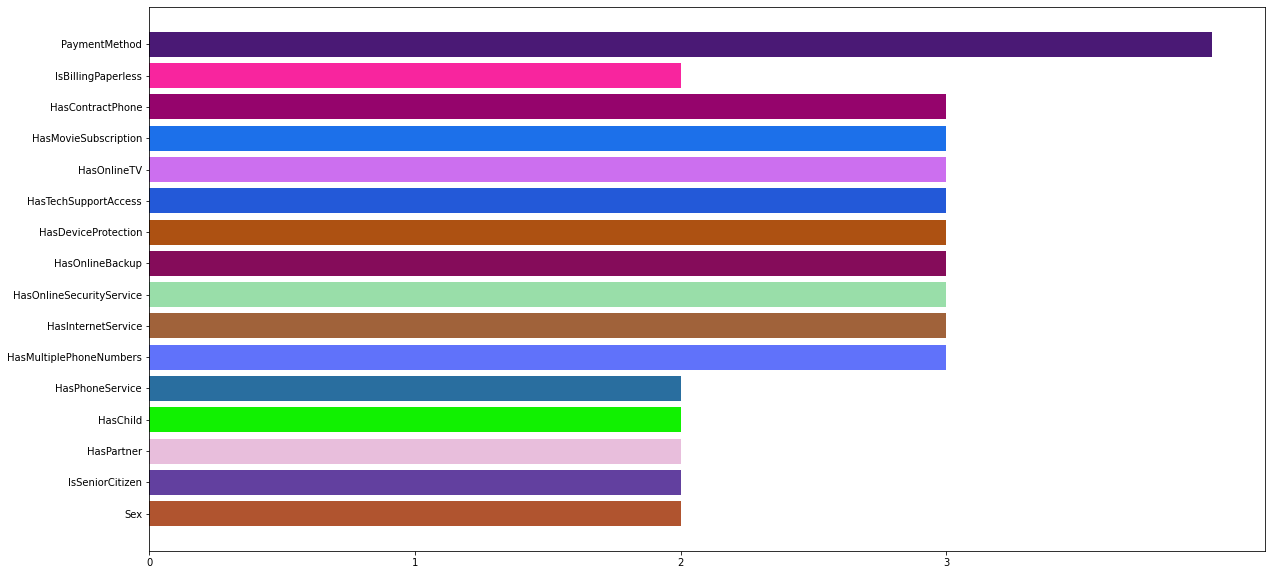

In [96]:
fig, axes = plt.subplots()
    
idx = [name for name in cat_cols]
vals = [X[name].value_counts().count() for name in cat_cols]
color_rectangle = np.random.rand(len(cat_cols), 3)
plt.barh(idx, vals, color=color_rectangle)
axes.set_xticks(list(range(max(vals))))

fig.set_figheight(10)

### Анализ целевой переменной

In [97]:
arr = y.value_counts()
arr

0    3898
1    1384
Name: Churn, dtype: int64

Text(0.5, 1.0, 'Соотношение классов')

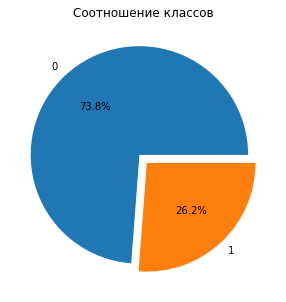

In [98]:
plt.pie(arr, labels=arr.index, autopct='%.1f%%', explode=[0.05]*2)
plt.title('Соотношение классов')

>**Вывод — классы сильно несбалансированы, необходимо будет стратифицировать выборку при кросс-валидации.**

### Кодирование признаков

In [99]:
labelencoder = LabelEncoder()

X_test = data_test.copy()

for name in cat_cols:
    labelencoder.fit(X[name])
    X[name] = labelencoder.transform(X[name])
    X_test[name] = labelencoder.transform(X_test[name])

##### One-hot encoding

In [100]:
X_trans = X.copy()
X_trans = pd.get_dummies(X_trans, columns=cat_cols)

#X_test = data_test.copy()
#X_test = pd.get_dummies(X_test, columns=cat_cols)

Разобьем датасет на тренировочный и валидационный:

In [101]:
X_train, X_valid, y_train, y_valid  = train_test_split(X_trans, y, train_size=0.8, stratify=y, random_state=42)

##### Стандартизация числовых признаков.

In [102]:
scaler = StandardScaler()
#scaler = RobustScaler()

In [103]:
scaler.fit(X_train[num_cols]) # вычисляем параметры на обучающей выборке

X_train_scaled = scaler.transform(X_train[num_cols])
X_valid_scaled = scaler.transform(X_valid[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

for name in num_cols:
    X_train[name] = X_train_scaled[:, num_cols.index(name)]
    X_valid[name] = X_valid_scaled[:, num_cols.index(name)]
    X_test[name] = X_test_scaled[:, num_cols.index(name)]

### Линейные модели

In [104]:
clf = LogisticRegression(solver='liblinear',
                         penalty='l2',
                         max_iter=500,
                         random_state=42)

clf.fit(X_train, y_train);

In [105]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

0.8547023974821808

Результат неплохой, попробуем улучшить:

In [106]:
clf = LogisticRegressionCV(
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    penalty='l2',
    solver='sag',
    refit=True,
    max_iter=500,
    random_state=42)

clf.fit(X_train, y_train);

In [107]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

0.855100435064334

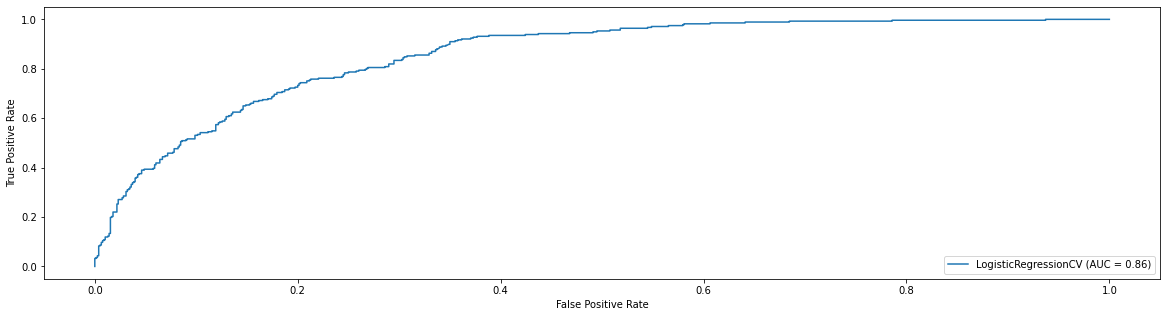

In [108]:
metrics.plot_roc_curve(clf, X_valid, y_valid);

### K-ближайших соседей

In [109]:
clf = KNeighborsClassifier(n_neighbors=66,
                           leaf_size=30,
                           algorithm='brute',
                           p=4,
                           n_jobs=-1)
clf.fit(X_train, y_train);

In [110]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

0.8521845783578638

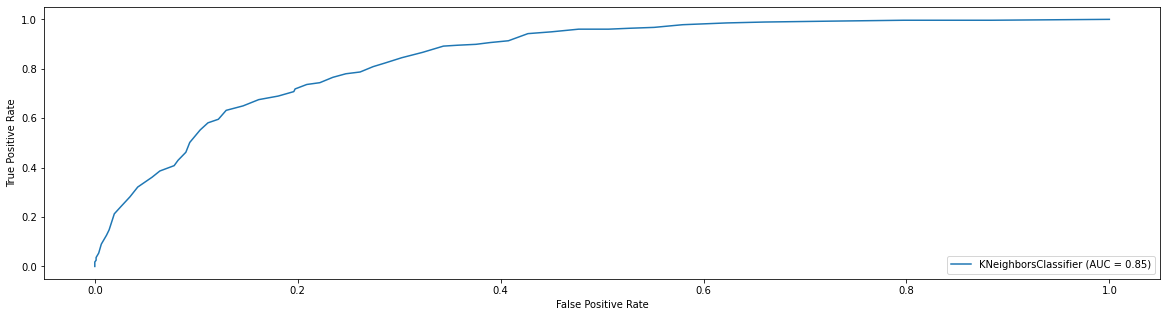

In [111]:
metrics.plot_roc_curve(clf, X_valid, y_valid);

>KNN явно уступает по качеству

### Градиентный бустинг

Еще раз разобьем выборку из исходного датасета

In [112]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [113]:
clf = GradientBoostingClassifier(
    n_estimators=85,
    learning_rate=0.1,
    max_features='sqrt',
    criterion='friedman_mse',
    max_depth=2,
    random_state=42,
    warm_start=False)

clf.fit(X_train, y_train);

In [114]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.8573289826899936

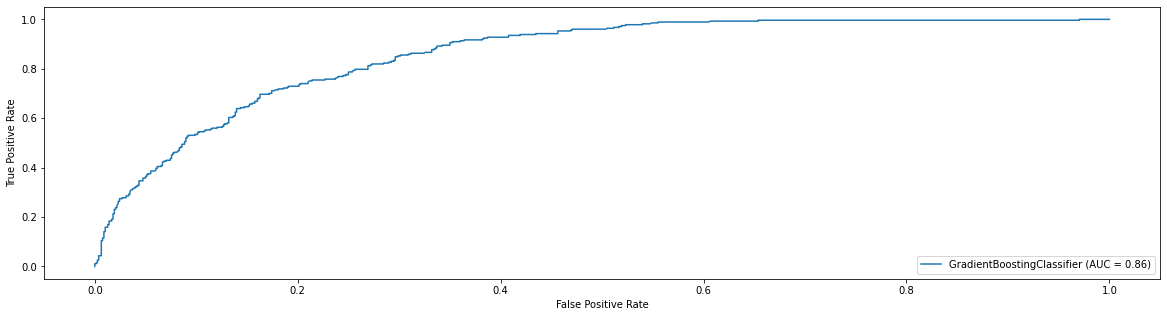

In [115]:
metrics.plot_roc_curve(clf, X_valid, y_valid);

##### XGBoost

In [116]:
clf = xgb.XGBClassifier(use_label_encoder=False,
                        max_depth=4,
                        booster='gbtree',
                        n_estimators=19,
                        reg_lambda=0.9,
                        min_child_weight=0.3,
                        learning_rate=0.06,
                        n_jobs=-1,
                        random_state=42)

clf.fit(X_train, y_train,
        eval_metric='auc',
        verbose=True);

In [117]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.8558803110247153

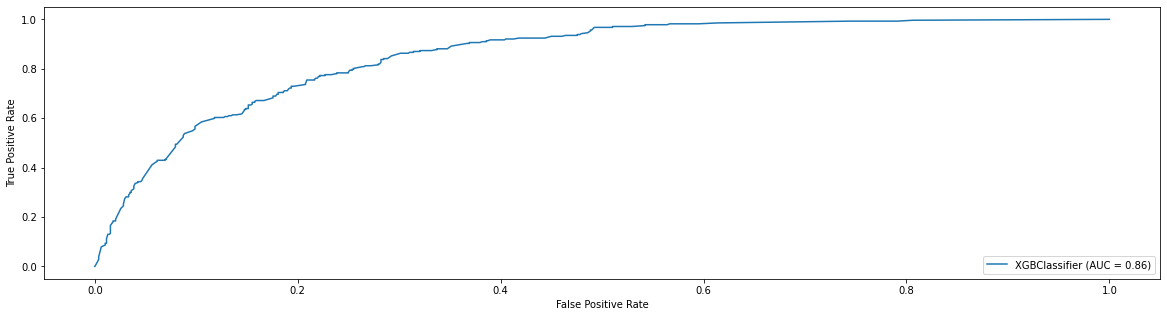

In [118]:
metrics.plot_roc_curve(clf, X_valid, y_valid);

##### CatBoost

In [120]:
clf = CatBoostClassifier(
    eval_metric='AUC:hints=skip_train~false',
    cat_features=cat_cols,
    l2_leaf_reg=9,
    iterations=500,
    grow_policy='Lossguide',
    depth=10,
    learning_rate=0.01,
    random_seed=42,
    logging_level='Silent'
)

eval_dataset = Pool(data=X_valid,
                    label=y_valid,
                    cat_features=cat_cols)

clf.fit(
    X_train, y_train,
    eval_set=eval_dataset,
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [121]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.8566486161251504

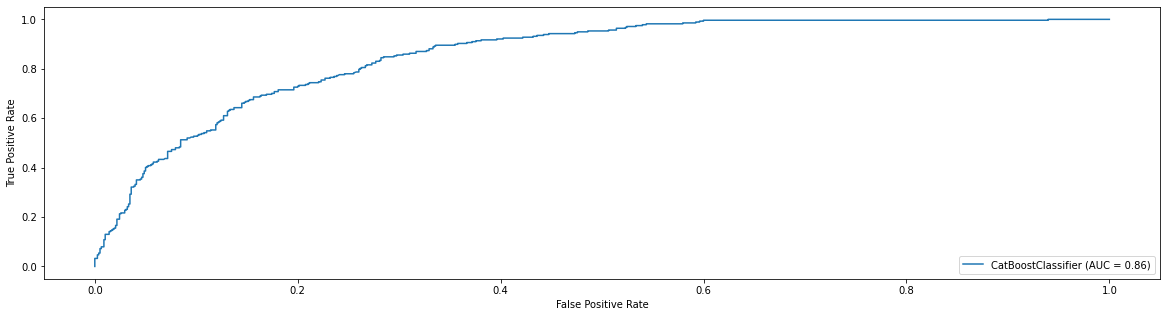

In [122]:
metrics.plot_roc_curve(clf, X_valid, y_valid);

# Предсказания

Лучшим по результатам предсказаний оказался градиентный бустинг

In [ ]:
best_model = clf

In [ ]:
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)